# BBB inference model
<a href="https://colab.research.google.com/drive/1OaL9PiCjwJ9h9QLxbrgRJujw_ekR_6zf?usp=drive_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @markdown **Execute this block to set-up your environment.<br>**
# @markdown This step will install all dependent packages and create a virtual environment that can run the BBB model.
%%bash

export NCCL_ASYNC_ERROR_HANDLING=1
export OMP_NUM_THREADS=1

cd /content
GIT_REPO='https://github.com/LicoriceLin/Uni-Mol.git'
UNICORE_URL='https://github.com/dptech-corp/Uni-Core/releases/download/0.0.2/unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl'
WEIGHT_URL='https://github.com/sjtugrc/NMDA_demo/releases/download/v1/demo_bbb_model.pt'
if [ ! -f UNIMOL_READY ]; then
  wget -q ${UNICORE_URL}
  pip3 -q install "unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl"
  git clone -b main ${GIT_REPO}
  cd ./Uni-Mol/unimol
  python setup.py develop
  cd -
  pip install -q rdkit
  pip install -q biopandas
  pip install -q py3Dmol
  git clone https://github.com/sjtugrc/NMDA_demo.git
  wget -q ${WEIGHT_URL}

  touch UNIMOL_READY
fi

running develop
running egg_info
creating unimol.egg-info
writing unimol.egg-info/PKG-INFO
writing dependency_links to unimol.egg-info/dependency_links.txt
writing requirements to unimol.egg-info/requires.txt
writing top-level names to unimol.egg-info/top_level.txt
writing manifest file 'unimol.egg-info/SOURCES.txt'
reading manifest file 'unimol.egg-info/SOURCES.txt'
writing manifest file 'unimol.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.10/dist-packages/unimol.egg-link (link to .)
unimol 1.0.0 is already the active version in easy-install.pth

Installed /content/Uni-Mol/unimol
Processing dependencies for unimol==1.0.0
Searching for pandas==1.5.3
Best match: pandas 1.5.3
Adding pandas 1.5.3 to easy-install.pth file

Using /usr/local/lib/python3.10/dist-packages
Searching for numpy==1.22.4
Best match: numpy 1.22.4
Adding numpy 1.22.4 to easy-install.pth file
Installing f2py script to /usr/local/bin
Installing f2py3 script to /usr/local/bin
Installing f2py3.

Cloning into 'Uni-Mol'...
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-base

In [ ]:
# @markdown **Execute this block to pre-process your data.<br>**
# @markdown If you want to inference your own data, please upload it and modify the parameter `input_data_path`(path to your .csv file) to the path of the data, otherwise the default data will be used (Kadry et al. 2020). <br>
# @markdown This step will convert the data you need to infer from the csv format to the lmdb format which is acceptable to the BBB model. (~5min for default case)
# @markdown - `input_data_path`: The path where the data you need to infer is located
# @markdown - `output_data_path`: The path to save your result
# @markdown - `seed`: The random seed used to regulate the sampling process of the original data
input_data_path='/content/NMDA_demo/bbb_data.csv' # @param {type:"string"}
output_data_path='/content/test_case' # @param {type:"string"}
seed=6 # @param {type:"string"}
import os
import sys
import pickle
import lmdb
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings(action='ignore')
from multiprocessing import Pool

def smi2scaffold(smi):
    try:
        return MurckoScaffold.MurckoScaffoldSmiles(
            smiles=smi, includeChirality=True)
    except:
        print("failed to generate scaffold with smiles: {}".format(smi))
        return smi

def smi2_2Dcoords(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = AllChem.AddHs(mol)
    AllChem.Compute2DCoords(mol)
    coordinates = mol.GetConformer().GetPositions().astype(np.float32)
    len(mol.GetAtoms()) == len(coordinates), "2D coordinates shape is not align with {}".format(smi)
    return coordinates

def smi2_3Dcoords(smi,cnt):
    mol = Chem.MolFromSmiles(smi)
    mol = AllChem.AddHs(mol)
    coordinate_list=[]
    for seed in range(cnt):
        try:
            res = AllChem.EmbedMolecule(mol, randomSeed=seed)  # will random generate conformer with seed equal to -1. else fixed random seed.
            if res == 0:
                try:
                    AllChem.MMFFOptimizeMolecule(mol)       # some conformer can not use MMFF optimize
                    coordinates = mol.GetConformer().GetPositions()
                except:
                    print("Failed to generate 3D, replace with 2D")
                    coordinates = smi2_2Dcoords(smi)

            elif res == -1:
                mol_tmp = Chem.MolFromSmiles(smi)
                AllChem.EmbedMolecule(mol_tmp, maxAttempts=5000, randomSeed=seed)
                mol_tmp = AllChem.AddHs(mol_tmp, addCoords=True)
                try:
                    AllChem.MMFFOptimizeMolecule(mol_tmp)       # some conformer can not use MMFF optimize
                    coordinates = mol_tmp.GetConformer().GetPositions()
                except:
                    print("Failed to generate 3D, replace with 2D")
                    coordinates = smi2_2Dcoords(smi)
        except:
            print("Failed to generate 3D, replace with 2D")
            coordinates = smi2_2Dcoords(smi)

        assert len(mol.GetAtoms()) == len(coordinates), "3D coordinates shape is not align with {}".format(smi)
        coordinate_list.append(coordinates.astype(np.float32))
    return coordinate_list

def inner_smi2coords(content):
    smi = content[0]
    target = content[1:]
    cnt = 10 # conformer num,all==11, 10 3d + 1 2d
    scaffold = smi2scaffold(smi)

    mol = Chem.MolFromSmiles(smi)
    if len(mol.GetAtoms()) > 400:
        coordinate_list =  [smi2_2Dcoords(smi)] * (cnt+1)
        print("atom num >400,use 2D coords",smi)
    else:
        coordinate_list = smi2_3Dcoords(smi,cnt)
        coordinate_list.append(smi2_2Dcoords(smi).astype(np.float32))
    mol = AllChem.AddHs(mol)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]  # after add H
    return pickle.dumps({'atoms': atoms,
    'coordinates': coordinate_list,
    'mol':mol,'smi': smi, 'scaffold': scaffold, 'target': target}, protocol=-1)

def smi2coords(content):
    try:
        return inner_smi2coords(content)
    except:
        print("failed smiles: {}".format(content[0]))
        return None

def write_lmdb(inpath='./', outpath='./', nthreads=16):
    test = pd.read_csv(inpath)
    if inpath == '/content/NMDA_demo/bbb_data.csv':
        test = test.sample(n=200, random_state=seed)

    for name, content_list in [('test.lmdb', zip(*[test[c].values.tolist() for c in test]))]:
        os.makedirs(outpath, exist_ok=True)
        output_name = os.path.join(outpath, name)
        try:
            os.remove(output_name)
        except:
            pass
        env_new = lmdb.open(
            output_name,
            subdir=False,
            readonly=False,
            lock=False,
            readahead=False,
            meminit=False,
            max_readers=1,
            map_size=int(100e9),
        )
        txn_write = env_new.begin(write=True)
        with Pool(nthreads) as pool:
            i = 0
            for inner_output in tqdm(pool.imap(smi2coords, content_list)):
                if inner_output is not None:
                    txn_write.put(f'{i}'.encode("ascii"), inner_output)
                    i += 1
            print('{} process {} lines'.format(name, i))
            txn_write.commit()
            env_new.close()

write_lmdb(input_data_path,output_data_path)

200it [04:56,  1.48s/it]


test.lmdb process 200 lines


In [ ]:
# @markdown **Execute this block to infer your data.<br>**
# @markdown This step will complete inference based on the pretrain model. (~5min for default case)
# @markdown - `infer_weight_path`: The path where the pre-trained model weights are located
# @markdown - `batch_size`: The number of samples selected for one training
# default parameters
task_type='classification'
num_classes=2
loss_func="finetune_cross_entropy"
metric="valid_agg_auc"
extra_paras='--maximize-best-checkpoint-metric'
only_polar=0
infer_weight_path='/content/demo_bbb_model.pt'# @param {type:"string"}
batch_size="64" # @param {type:"string"}
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'


# inference
import pandas as pd
from glob import glob
import re,os
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve,
                average_precision_score, confusion_matrix, ConfusionMatrixDisplay)

def sort_key(s):
    match = re.match(r'([\w/]+checkpoint)((\d+)|(_.+))\.pt', s)
    if match:
        prefix = match.group(1)
        if match.group(2).startswith('_'):
            return (1, match.group(2))

        else:
            return (0, int(match.group(2)))
    return (2, s)

def split_testfile(test_file:str):
    _,subset=os.path.split(test_file)
    subset=subset.replace('.lmdb','')
    result_path=os.path.join(_,subset+'_result')
    data_path,task_name=os.path.split(_)
    return data_path,task_name,subset,result_path

def split_list_col(df:pd.DataFrame,column_to_split:str):
    where_column_to_split=df.columns.get_loc(column_to_split)
    column_data = df.pop(column_to_split)
    try:
      try:
        len_column_data=len(column_data[0])
      except:
        len_column_data=1
      split_columns = pd.DataFrame(column_data.tolist(),
                        columns=[f'{column_to_split}_{i + 1}'
                        for i in range(len_column_data)])
    except:
      import pdb;pdb.set_trace()
    df_out = pd.concat([df.iloc[:, :where_column_to_split],
                        split_columns, df.iloc[:, where_column_to_split:]], axis=1)
    return df_out

def get_csv_results(predict_path):
  predict = pd.read_pickle(predict_path)
  smi_list, predict_list,target_list = [], [], []
  for batch in predict:
      sz = batch["bsz"]
      infer_name='prob' if task_type=='classification' else 'predict'
      for i in range(sz):
        smi_list.append(batch["smi_name"][i])
        predict_list.append(batch[infer_name][i].tolist())
        target_list.append(batch['target'][i].tolist())
  predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list,"target":target_list})
  predict_df=split_list_col(predict_df,"predict")
  if task_type=='regression':
    predict_df=split_list_col(predict_df,"target")

  predict_df = predict_df.groupby("SMILES")[
      [i for i in predict_df if i !='SMILES']].mean().reset_index()
  predict_df.to_csv(predict_path.replace('.out.pkl','.full.csv'),index=False)

  if task_type=='classification':
    demo_predict_list = [i[1] for i in predict_list]
    demo_target_list = [i for i in target_list]
  else:
    demo_predict_list = [i[0] for i in predict_list]
    demo_target_list = [i[0] for i in target_list]
  demo_predict_df = pd.DataFrame({"SMILES": smi_list, "predict":demo_predict_list ,"target":demo_target_list})
  demo_predict_df = demo_predict_df.groupby("SMILES")[["predict","target"]].mean().reset_index()
  demo_predict_df.to_csv(predict_path.replace('.out.pkl','.csv'),index=False)
  return demo_predict_df


conf_size=11
infer_extra_paras=''

# if data_path.endswith('.lmdb'):
#   (test_data_path,test_task_name,
#   test_subset,test_result_path)=split_testfile(data_path)
# elif data_path.endswith('.csv'):
#   _=data_path.replace('.csv','.lmdb')
#   if not os.path.isfile(_):
#     flags=f'-data {data_path} --seed {seed}'
#     !python NMDA_deeplearning_example/preprocess.py $flags
#   (test_data_path,test_task_name,
#   test_subset,test_result_path)=split_testfile(_)
# else:
#   raise ValueError
data_path, task_name = os.path.dirname(output_data_path), os.path.basename(output_data_path)


id=os.path.basename(infer_weight_path).replace('.pt','')
flags=f'''--user-dir /content/Uni-Mol/unimol/unimol {data_path} \
  --task-name {task_name} --valid-subset test \
  --results-path {output_data_path} \
  --num-workers 8 --ddp-backend=c10d --batch-size {batch_size} \
  --task mol_finetune --loss {loss_func} --arch unimol_base \
  --classification-head-name {task_name} --num-classes {num_classes} \
  --dict-name {dict_name} --conf-size {conf_size} \
  --only-polar {only_polar}  \
  --path {infer_weight_path}  \
  --bf16 --log-interval 50 --log-format simple {infer_extra_paras}'''

!python /content/Uni-Mol/unimol/unimol/infer.py $flags

2023-07-01 02:16:16.304099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 02:16:17.800422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_softmax is not installed corrected
2023-07-01 02:16:21 | INFO | unimol.inference | loading model(s) from /content/demo_bbb_model.pt
2023-07-01 02:16:22 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2023-07-01 02:16:24 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='simple', tensorboard_logdir='', seed=1, cpu=False, fp16=False, bf16=True, bf16_sr=False, allreduce_fp32

                              SMILES   predict  target
0                C(C(C(CC)C)C(N)=O)C  0.435589     1.0
1          C(C(C(NC(N)=O)=O)(CC)Br)C  0.498673     1.0
2   C(C(C(OCOC(C(C)(C)C)=O)=O)CCC)CC  0.465742     1.0
3  C(C(Cl)(Cl)Cl)OC(OCC(Cl)(Cl)Cl)=O  0.443637     1.0
4           C(C(N1C(CCC1)=O)C(N)=O)C  0.448970     1.0


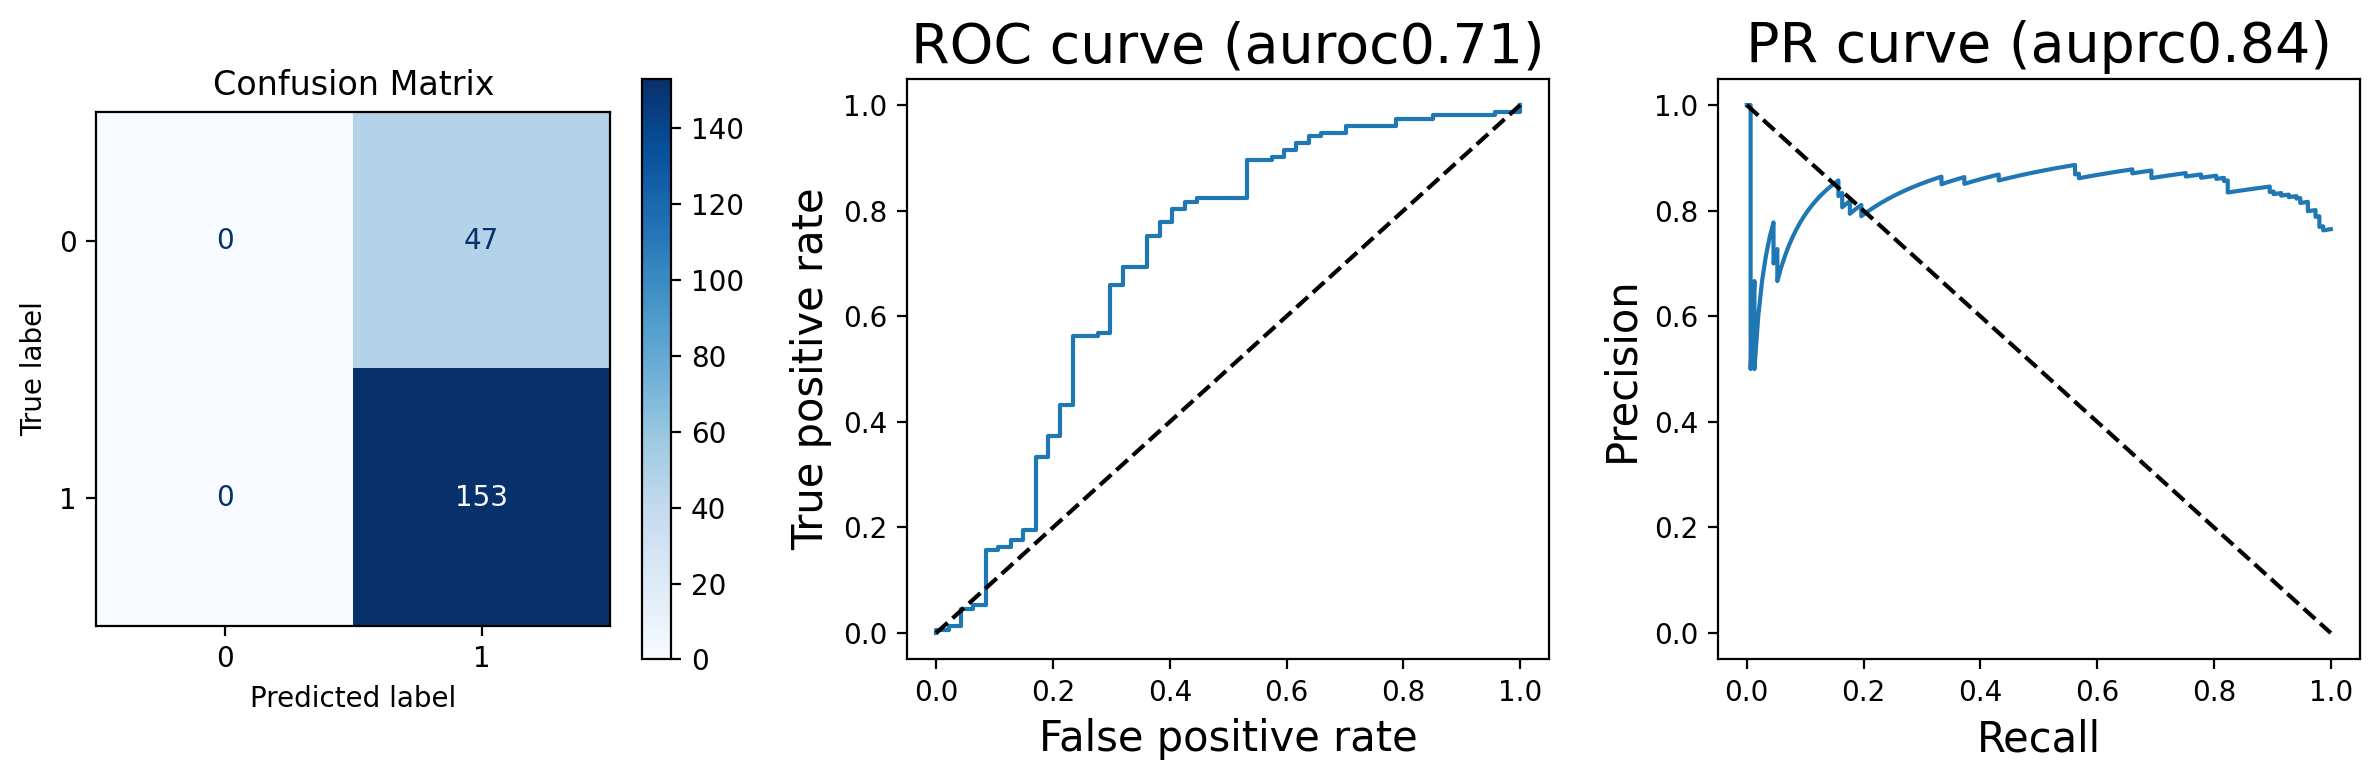

In [ ]:
# @markdown **Execute this block to show your result and visualize your prediction. <br>**
# @markdown This step will display the first five rows of your results and visualize the results of the entire inference
fname = infer_weight_path.split("/")[-2]
save_path = f"{output_data_path}/content_test.out.pkl"
infer_result=get_csv_results(save_path)
print(infer_result.head(5))
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
if task_type=='regression':
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    axes.scatter(infer_result['target'], infer_result['predict'])
    min_max_ = [infer_result['target'].min(),infer_result['target'].max()]
    axes.plot(min_max_,min_max_,'--',c='grey',label='x=y')

    axes.set_xlabel('Target', fontsize=15)
    axes.set_ylabel('Predict',fontsize=15)
    r2 = r2_score(infer_result['predict'],infer_result['target'])
    mse = mean_squared_error(infer_result['predict'],infer_result['target'])
    axes.set_title("Regression Curve",fontsize=20)
    plt.text(0.95, 0.1, f'MSE: {mse:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=13)
    plt.text(0.95, 0.05, f'R2: {r2:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=13)
    fig.set_dpi(200)
else:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fpr, tpr, _ = roc_curve(infer_result['target'], infer_result['predict'])


    pred_label = [1 if i > 0.1 else 0 for i in infer_result['predict']]
    cm = confusion_matrix(infer_result['target'], pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap='Blues', values_format='.0f',ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    axes[1].plot(fpr, tpr)
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel('False positive rate', fontsize=15)
    axes[1].set_ylabel('True positive rate', fontsize=15)
    auroc = roc_auc_score(infer_result['target'], infer_result['predict'])
    axes[1].set_title(f'ROC curve (auroc{auroc:.2f})', fontsize=20)

    auprc = average_precision_score(
        infer_result['target'], infer_result['predict'])
    precision, recall, _ = precision_recall_curve(
        infer_result['target'], infer_result['predict'])
    axes[2].plot(recall, precision, label=f"PR curve (AUPRC={auprc:.2f})")
    axes[2].set_xlabel('Recall', fontsize=15)
    axes[2].set_ylabel('Precision', fontsize=15)
    axes[2].set_title(f'PR curve (auprc{auprc:.2f})', fontsize=20)
    axes[2].plot([0, 1], [1, 0], 'k--')

    fig.set_dpi(200)
plt.tight_layout()
plt.show()